In [1]:
import os
import sys
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn import decomposition
from matplotlib.backends.backend_pdf import PdfPages
import importlib

sys.path.append('../')
import catrace
from catrace import dataio
import catrace.process_time_trace as ptt
import catrace.plot_trace as pltr
import catrace.pattern_correlation as pcr
import catrace.manifold_embed as emb
import catrace.exp_collection as ecl
from catrace.frame_time import convert_sec_to_frame
from catrace.trace_dataframe import concatenate_planes
importlib.reload(catrace.plot_trace)
importlib.reload(ecl)
importlib.reload(pcr)


<module 'catrace.pattern_correlation' from '/home/hubo/Projects/Ca_imaging/scripts/cca/../catrace/pattern_correlation.py'>

## Load all dataset

In [ ]:
exp_list = [( '2021-02-05-DpOBEM-JH9','phe'),
            ('2021-03-18-DpOBEM-JH10','phe'),
            ('2021-03-19-DpOBEM-JH10','phe'),
            ('2021-04-02-DpOBEM-JH11','phe'),
            ('2021-04-03-DpOBEM-JH11','phe'),
            ('2021-05-01-DpOBEM-JH13','phe'),
            ('2021-05-22-DpOBEM-JH14','phe'),
            ('2021-07-15-DpOBEM-N2'  ,'naive'),
            ('2021-07-16-DpOBEM-N3' ,'naive'),
            ('2021-07-30-DpOBEM-JH17','arg'),
            ('2021-07-31-DpOBEM-JH17','arg'),
            ('2021-09-02-DpOBEM-JH18','arg'),
            ('2021-09-03-DpOBEM-JH18','arg'),
            ('2021-09-04-DpOBEM-JH18','arg'),
            ('2021-09-15-DpOBEM-JH20','phe'),
            ('2021-09-17-DpOBEM-JH20','phe'),
            ('2021-09-18-DpOBEM-JH20','phe')]
region_list = ['Dp', 'OB']
frame_rate = 30/4
#num_trial = 3
exp_info = dict(num_trial=3)
odor_list = ['phe', 'trp', 'arg', 'tdca', 'tca', 'gca', 'acsf', 'spont']
#plane_nb_list = np.array([1,2,3,4]) - 1

In [3]:
data_root_dir = '/home/hubo/Projects/Ca_imaging/results/'
dfovf_dict = dict()
for exp in exp_list:
    exp_name = exp[0]
    dfovf_dict[exp_name] = dict()
    for region in region_list:
        print(exp_name, region)
        dfovf_dict[exp_name][region] = ecl.load_dfovf(data_root_dir,
                                                  exp_name, region)

2021-02-05-DpOBEM-JH9 Dp
2021-02-05-DpOBEM-JH9 OB
2021-03-18-DpOBEM-JH10 Dp
2021-03-18-DpOBEM-JH10 OB
2021-03-19-DpOBEM-JH10 Dp
2021-03-19-DpOBEM-JH10 OB
2021-04-02-DpOBEM-JH11 Dp
2021-04-02-DpOBEM-JH11 OB
2021-04-03-DpOBEM-JH11 Dp
2021-04-03-DpOBEM-JH11 OB
2021-05-01-DpOBEM-JH13 Dp
2021-05-01-DpOBEM-JH13 OB
2021-05-22-DpOBEM-JH14 Dp
2021-05-22-DpOBEM-JH14 OB
2021-07-15-DpOBEM-N2 Dp
2021-07-15-DpOBEM-N2 OB
2021-07-16-DpOBEM-N3 Dp
2021-07-16-DpOBEM-N3 OB
2021-07-30-DpOBEM-JH17 Dp
2021-07-30-DpOBEM-JH17 OB
2021-07-31-DpOBEM-JH17 Dp
2021-07-31-DpOBEM-JH17 OB
2021-09-02-DpOBEM-JH18 Dp
2021-09-02-DpOBEM-JH18 OB
2021-09-03-DpOBEM-JH18 Dp
2021-09-03-DpOBEM-JH18 OB
2021-09-04-DpOBEM-JH18 Dp
2021-09-04-DpOBEM-JH18 OB
2021-09-15-DpOBEM-JH20 Dp
2021-09-15-DpOBEM-JH20 OB
2021-09-17-DpOBEM-JH20 Dp
2021-09-17-DpOBEM-JH20 OB
2021-09-18-DpOBEM-JH20 Dp
2021-09-18-DpOBEM-JH20 OB


## Separate training conditions

In [4]:
csplus_dict = dict()
for exp in exp_list:
    if exp[1] not in csplus_dict.keys():
        csplus_dict[exp[1]] = []
    csplus_dict[exp[1]].append(exp[0])
csplus_dict

{'phe': ['2021-02-05-DpOBEM-JH9',
  '2021-03-18-DpOBEM-JH10',
  '2021-03-19-DpOBEM-JH10',
  '2021-04-02-DpOBEM-JH11',
  '2021-04-03-DpOBEM-JH11',
  '2021-05-01-DpOBEM-JH13',
  '2021-05-22-DpOBEM-JH14',
  '2021-09-15-DpOBEM-JH20',
  '2021-09-17-DpOBEM-JH20',
  '2021-09-18-DpOBEM-JH20'],
 'naive': ['2021-07-15-DpOBEM-N2', '2021-07-16-DpOBEM-N3'],
 'arg': ['2021-07-30-DpOBEM-JH17',
  '2021-07-31-DpOBEM-JH17',
  '2021-09-02-DpOBEM-JH18',
  '2021-09-03-DpOBEM-JH18',
  '2021-09-04-DpOBEM-JH18']}

## Select neurons
Select neurons based on maximum response divided by the standard deviation of its time course

In [5]:
select_neuron_explist = ecl.get_data_dict_decorator(exp_list, region_list, dfovf_dict, ptt.select_neuron)
thresh = 5.5
dfovf_select_dict = select_neuron_explist(thresh)

2021-02-05-DpOBEM-JH9 Dp
2021-02-05-DpOBEM-JH9 OB
2021-03-18-DpOBEM-JH10 Dp
2021-03-18-DpOBEM-JH10 OB
2021-03-19-DpOBEM-JH10 Dp
2021-03-19-DpOBEM-JH10 OB
2021-04-02-DpOBEM-JH11 Dp
2021-04-02-DpOBEM-JH11 OB
2021-04-03-DpOBEM-JH11 Dp
2021-04-03-DpOBEM-JH11 OB
2021-05-01-DpOBEM-JH13 Dp
2021-05-01-DpOBEM-JH13 OB
2021-05-22-DpOBEM-JH14 Dp
2021-05-22-DpOBEM-JH14 OB
2021-07-15-DpOBEM-N2 Dp
2021-07-15-DpOBEM-N2 OB
2021-07-16-DpOBEM-N3 Dp
2021-07-16-DpOBEM-N3 OB
2021-07-30-DpOBEM-JH17 Dp
2021-07-30-DpOBEM-JH17 OB
2021-07-31-DpOBEM-JH17 Dp
2021-07-31-DpOBEM-JH17 OB
2021-09-02-DpOBEM-JH18 Dp
2021-09-02-DpOBEM-JH18 OB
2021-09-03-DpOBEM-JH18 Dp
2021-09-03-DpOBEM-JH18 OB
2021-09-04-DpOBEM-JH18 Dp
2021-09-04-DpOBEM-JH18 OB
2021-09-15-DpOBEM-JH20 Dp
2021-09-15-DpOBEM-JH20 OB
2021-09-17-DpOBEM-JH20 Dp
2021-09-17-DpOBEM-JH20 OB
2021-09-18-DpOBEM-JH20 Dp
2021-09-18-DpOBEM-JH20 OB


## Plot average time course

In [6]:
plot_explist_trace_avg = ecl.plot_explist_decorator(pltr.plot_trace_avg, csplus_dict, dfovf_select_dict)

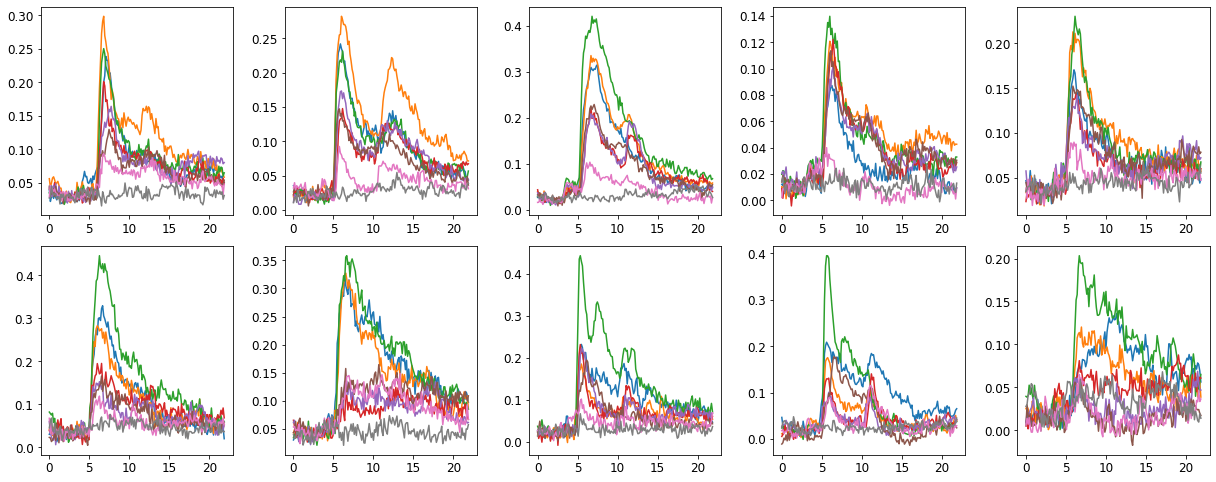

In [7]:
csplus = 'phe'
region = 'Dp'
odor_list = ['phe', 'trp', 'arg', 'tdca', 'tca', 'gca', 'acsf', 'spont']
frame_rate = 30/4
fig = plot_explist_trace_avg(csplus, region, odor_list, frame_rate)

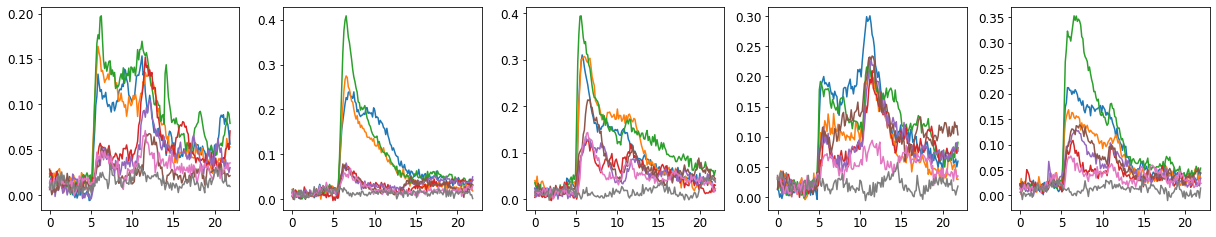

In [8]:
csplus = 'arg'
region = 'Dp'
fig = plot_explist_trace_avg(csplus, region, odor_list, frame_rate)

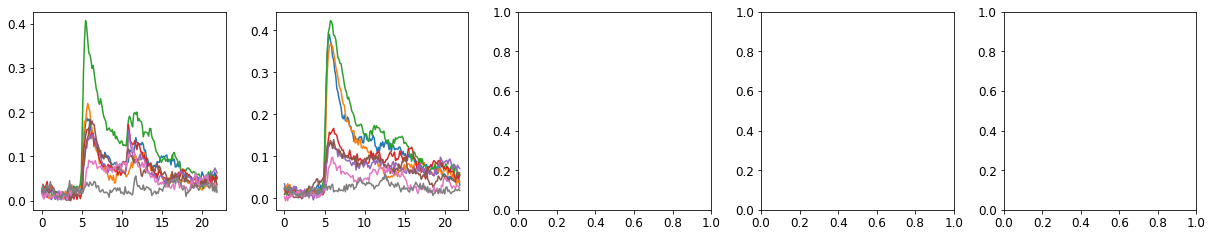

In [9]:
csplus = 'naive'
region = 'Dp'
fig = plot_explist_trace_avg(csplus, region, odor_list, frame_rate)

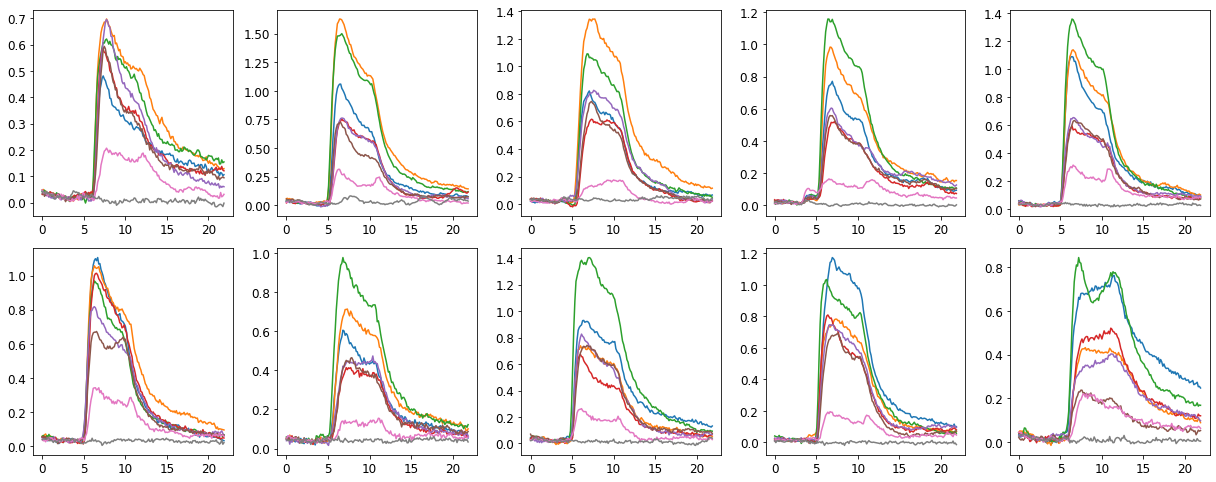

In [10]:
csplus = 'phe'
region = 'OB'
fig = plot_explist_trace_avg(csplus, region, odor_list, frame_rate)

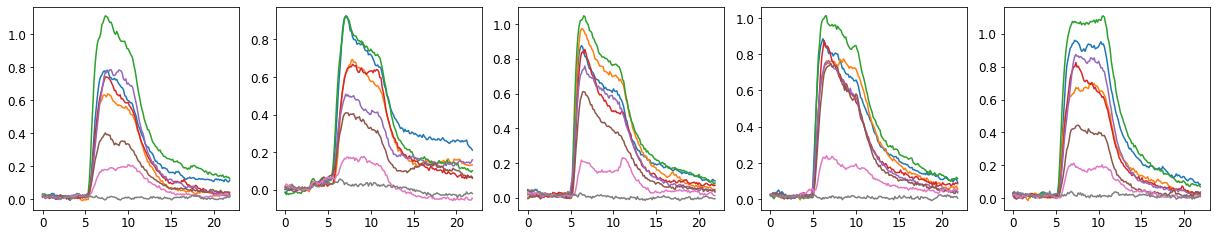

In [11]:
csplus = 'arg'
region = 'OB'
fig = plot_explist_trace_avg(csplus, region, odor_list, frame_rate)

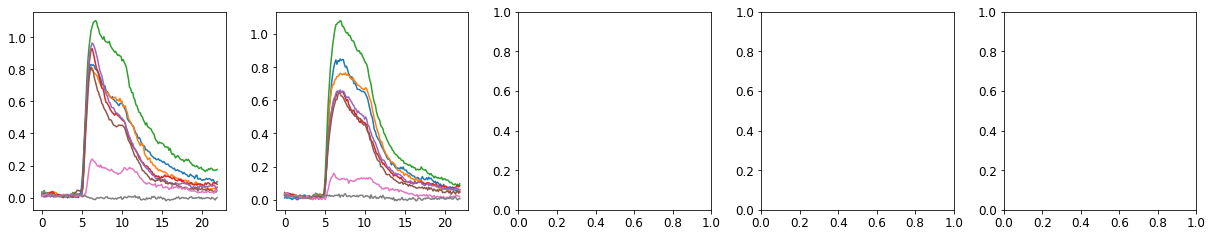

In [12]:
csplus = 'naive'
region = 'OB'
fig = plot_explist_trace_avg(csplus, region, odor_list, frame_rate)

## Compute and plot pattern correlation matrix

/home/hubo/Projects/Ca_imaging/scripts/cca/../catrace/exp_collection.py:18: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  pat = dfrestack.mean(level=[0, 1])
/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


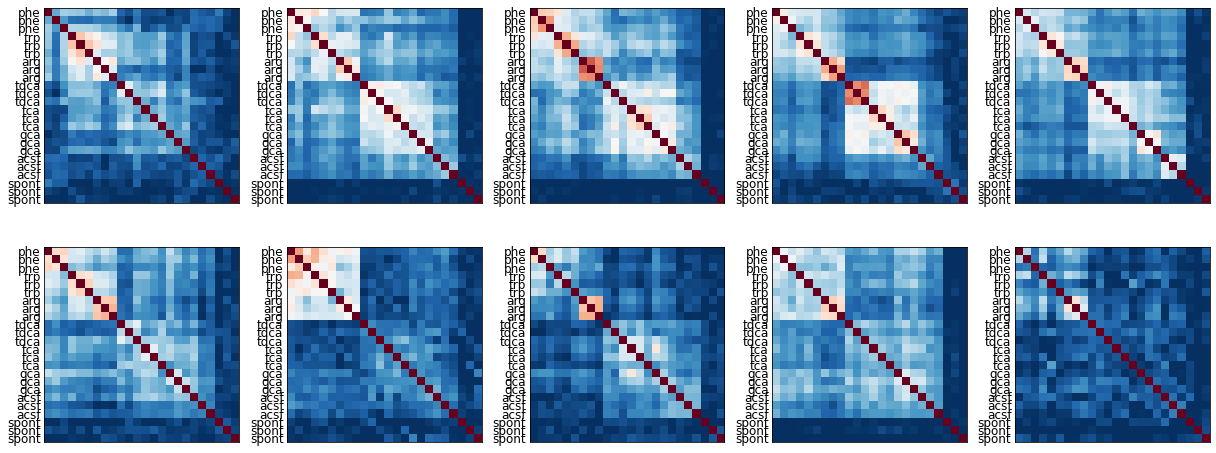

In [13]:
plot_explist_pattern_corr = ecl.plot_explist_decorator(ecl.plot_exp_pattern_correlation,csplus_dict,dfovf_dict,
                                                   sharey=False)
dp_time_window = [6,7]
csplus = 'phe'
region = 'Dp'
fig = plot_explist_pattern_corr(csplus, region, odor_list, frame_rate, time_window=dp_time_window)

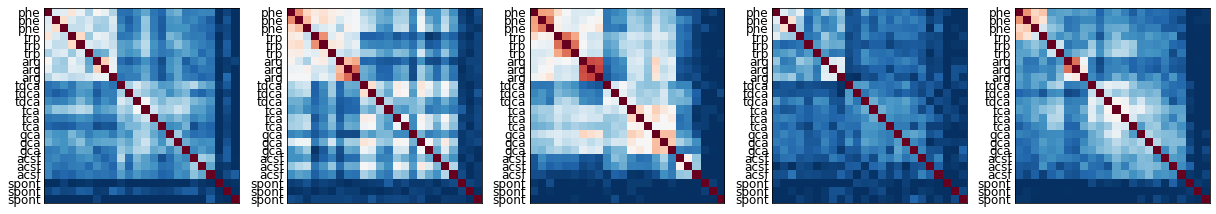

In [14]:
csplus = 'arg'
region = 'Dp'
fig = plot_explist_pattern_corr(csplus, region, odor_list, frame_rate, time_window=dp_time_window)

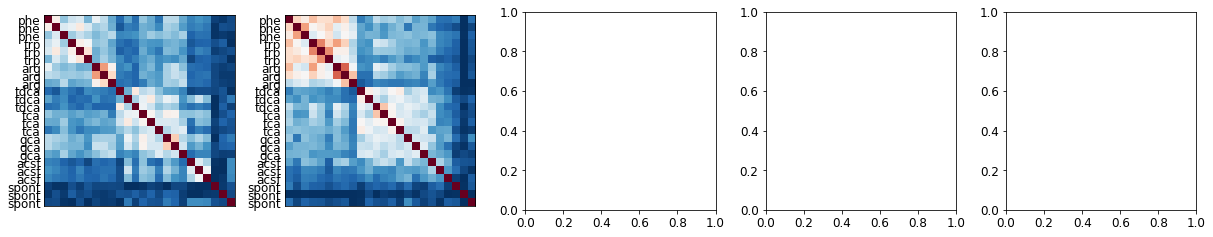

In [15]:
csplus = 'naive'
region = 'Dp'
fig = plot_explist_pattern_corr(csplus, region, odor_list, frame_rate, time_window=dp_time_window)

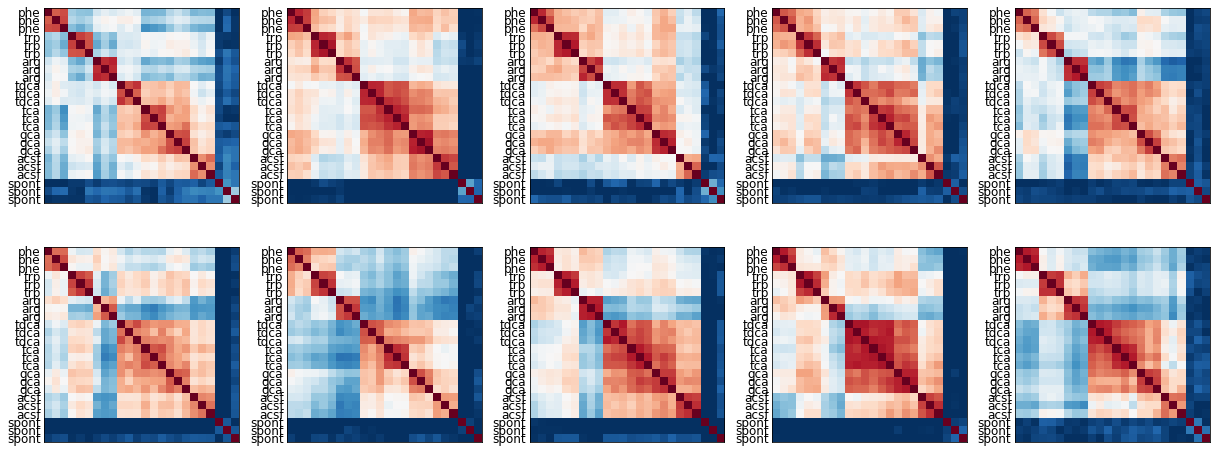

In [16]:
csplus = 'phe'
region = 'OB'
fig = plot_explist_pattern_corr(csplus, region, odor_list, frame_rate, time_window=[6,11])

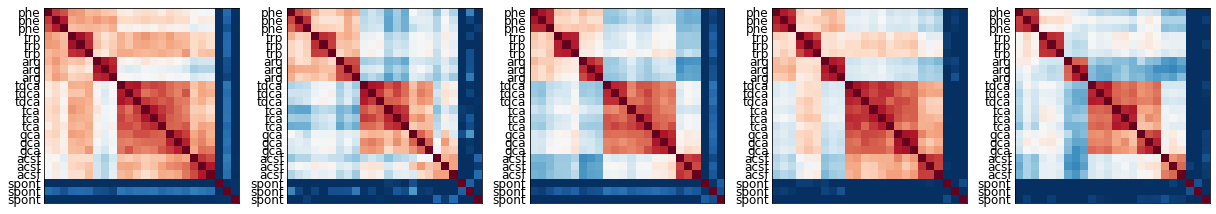

In [17]:
csplus = 'arg'
region = 'OB'
fig = plot_explist_pattern_corr(csplus, region, odor_list, frame_rate, time_window=[6,11])

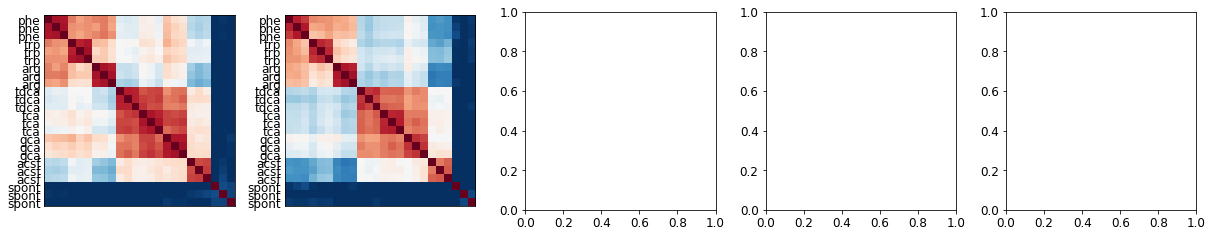

In [18]:
csplus = 'naive'
region = 'OB'
fig = plot_explist_pattern_corr(csplus, region, odor_list, frame_rate, time_window=[6,11])

## Bin over time-axis for further dimensionality reduction analysis

In [19]:
compute_pattern_explist = ecl.get_data_dict_decorator(exp_list, region_list, dfovf_dict, ptt.bin_and_restack)

In [20]:
tbin = 5
pattern_dict = compute_pattern_explist(tbin)

2021-02-05-DpOBEM-JH9 Dp
2021-02-05-DpOBEM-JH9 OB
2021-03-18-DpOBEM-JH10 Dp
2021-03-18-DpOBEM-JH10 OB
2021-03-19-DpOBEM-JH10 Dp
2021-03-19-DpOBEM-JH10 OB
2021-04-02-DpOBEM-JH11 Dp
2021-04-02-DpOBEM-JH11 OB
2021-04-03-DpOBEM-JH11 Dp
2021-04-03-DpOBEM-JH11 OB
2021-05-01-DpOBEM-JH13 Dp
2021-05-01-DpOBEM-JH13 OB
2021-05-22-DpOBEM-JH14 Dp
2021-05-22-DpOBEM-JH14 OB
2021-07-15-DpOBEM-N2 Dp
2021-07-15-DpOBEM-N2 OB
2021-07-16-DpOBEM-N3 Dp
2021-07-16-DpOBEM-N3 OB
2021-07-30-DpOBEM-JH17 Dp
2021-07-30-DpOBEM-JH17 OB
2021-07-31-DpOBEM-JH17 Dp
2021-07-31-DpOBEM-JH17 OB
2021-09-02-DpOBEM-JH18 Dp
2021-09-02-DpOBEM-JH18 OB
2021-09-03-DpOBEM-JH18 Dp
2021-09-03-DpOBEM-JH18 OB
2021-09-04-DpOBEM-JH18 Dp
2021-09-04-DpOBEM-JH18 OB
2021-09-15-DpOBEM-JH20 Dp
2021-09-15-DpOBEM-JH20 OB
2021-09-17-DpOBEM-JH20 Dp
2021-09-17-DpOBEM-JH20 OB
2021-09-18-DpOBEM-JH20 Dp
2021-09-18-DpOBEM-JH20 OB


## Standardize the data
Make the data center at zero, scale the data based on its maximum value

In [77]:
standardize_explist = ecl.get_data_dict_decorator(exp_list, region_list, pattern_dict, emb.quantile_all)
std_pattern_dict = standardize_explist(q=1)

2021-02-05-DpOBEM-JH9 Dp
2021-02-05-DpOBEM-JH9 OB
2021-03-18-DpOBEM-JH10 Dp
2021-03-18-DpOBEM-JH10 OB
2021-03-19-DpOBEM-JH10 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with 

2021-03-19-DpOBEM-JH10 OB
2021-04-02-DpOBEM-JH11 Dp
2021-04-02-DpOBEM-JH11 OB
2021-04-03-DpOBEM-JH11 Dp
2021-04-03-DpOBEM-JH11 OB
2021-05-01-DpOBEM-JH13 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with 

2021-05-01-DpOBEM-JH13 OB
2021-05-22-DpOBEM-JH14 Dp
2021-05-22-DpOBEM-JH14 OB
2021-07-15-DpOBEM-N2 Dp
2021-07-15-DpOBEM-N2 OB
2021-07-16-DpOBEM-N3 Dp
2021-07-16-DpOBEM-N3 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with 

2021-07-30-DpOBEM-JH17 Dp
2021-07-30-DpOBEM-JH17 OB
2021-07-31-DpOBEM-JH17 Dp
2021-07-31-DpOBEM-JH17 OB
2021-09-02-DpOBEM-JH18 Dp
2021-09-02-DpOBEM-JH18 OB
2021-09-03-DpOBEM-JH18 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with 

2021-09-03-DpOBEM-JH18 OB
2021-09-04-DpOBEM-JH18 Dp
2021-09-04-DpOBEM-JH18 OB
2021-09-15-DpOBEM-JH20 Dp
2021-09-15-DpOBEM-JH20 OB
2021-09-17-DpOBEM-JH20 Dp
2021-09-17-DpOBEM-JH20 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with 

2021-09-18-DpOBEM-JH20 Dp
2021-09-18-DpOBEM-JH20 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with 

## Principal component analysis

Perform PCA for all experiments

In [78]:
compute_pca_explist = ecl.get_data_dict_decorator(exp_list, region_list, std_pattern_dict, emb.compute_pca)

In [79]:
n_components = None
pca_all_dict = compute_pca_explist(n_components) 

2021-02-05-DpOBEM-JH9 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-02-05-DpOBEM-JH9 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-03-18-DpOBEM-JH10 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-03-18-DpOBEM-JH10 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-03-19-DpOBEM-JH10 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-03-19-DpOBEM-JH10 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-04-02-DpOBEM-JH11 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-04-02-DpOBEM-JH11 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-04-03-DpOBEM-JH11 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-04-03-DpOBEM-JH11 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-05-01-DpOBEM-JH13 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-05-01-DpOBEM-JH13 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-05-22-DpOBEM-JH14 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-05-22-DpOBEM-JH14 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-07-15-DpOBEM-N2 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-07-15-DpOBEM-N2 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-07-16-DpOBEM-N3 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-07-16-DpOBEM-N3 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-07-30-DpOBEM-JH17 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-07-30-DpOBEM-JH17 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-07-31-DpOBEM-JH17 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-07-31-DpOBEM-JH17 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-09-02-DpOBEM-JH18 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-09-02-DpOBEM-JH18 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-09-03-DpOBEM-JH18 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-09-03-DpOBEM-JH18 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-09-04-DpOBEM-JH18 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-09-04-DpOBEM-JH18 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-09-15-DpOBEM-JH20 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-09-15-DpOBEM-JH20 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-09-17-DpOBEM-JH20 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-09-17-DpOBEM-JH20 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-09-18-DpOBEM-JH20 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-09-18-DpOBEM-JH20 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


### Plot the explained variance ratio

['2021-02-05-DpOBEM-JH9', '2021-03-18-DpOBEM-JH10', '2021-03-19-DpOBEM-JH10', '2021-04-02-DpOBEM-JH11', '2021-04-03-DpOBEM-JH11', '2021-05-01-DpOBEM-JH13', '2021-05-22-DpOBEM-JH14', '2021-09-15-DpOBEM-JH20', '2021-09-17-DpOBEM-JH20', '2021-09-18-DpOBEM-JH20']


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

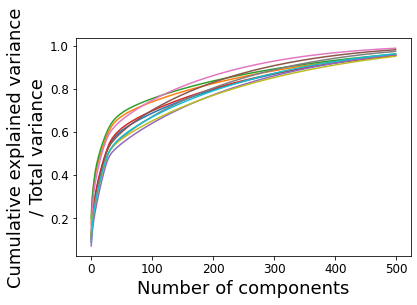

In [90]:
region = 'Dp'
csplus = 'phe'
xexp_list = csplus_dict[csplus]
print(xexp_list)
plt.subplots()#figsize=[10,10])
for exp in xexp_list:
    pca1 = pca_all_dict[exp][region]['pca']
    plt.plot(np.cumsum(pca1.explained_variance_ratio_[:500]),label=exp)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance\n/ Total variance')
plt.tight_layout
#plt.legend()



['2021-02-05-DpOBEM-JH9', '2021-03-18-DpOBEM-JH10', '2021-03-19-DpOBEM-JH10', '2021-04-02-DpOBEM-JH11', '2021-04-03-DpOBEM-JH11', '2021-05-01-DpOBEM-JH13', '2021-05-22-DpOBEM-JH14', '2021-09-15-DpOBEM-JH20', '2021-09-17-DpOBEM-JH20', '2021-09-18-DpOBEM-JH20']


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

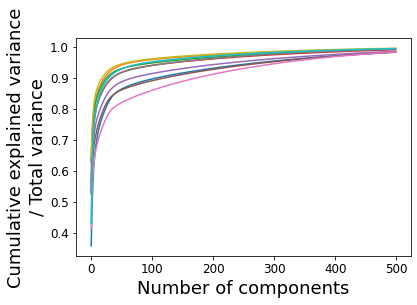

In [98]:
region = 'OB'
csplus = 'phe'
xexp_list = csplus_dict[csplus]
print(xexp_list)
plt.subplots()#figsize=[10,10])
for exp in xexp_list:
    pca1 = pca_all_dict[exp][region]['pca']
    plt.plot(np.cumsum(pca1.explained_variance_ratio_[:500]),label=exp)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance\n/ Total variance')
plt.tight_layout
#plt.legend()

['2021-07-30-DpOBEM-JH17', '2021-07-31-DpOBEM-JH17', '2021-09-02-DpOBEM-JH18', '2021-09-03-DpOBEM-JH18', '2021-09-04-DpOBEM-JH18']


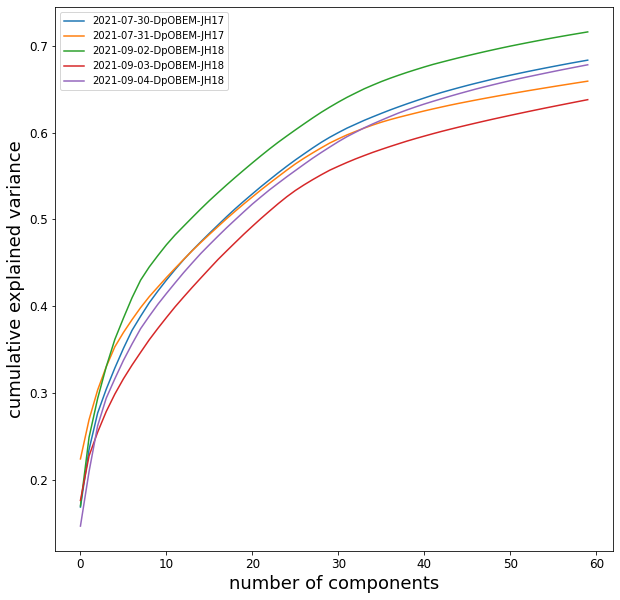

In [32]:
region = 'Dp'
csplus = 'arg'
xexp_list = csplus_dict[csplus]
plt.subplots(figsize=[10,10])
print(xexp_list)
for exp in xexp_list:
    pca1 = pca_all_dict[exp][region]['pca']
    plt.plot(np.cumsum(pca1.explained_variance_ratio_[:60]),label=exp)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.legend()



['2021-07-15-DpOBEM-N2', '2021-07-16-DpOBEM-N3']


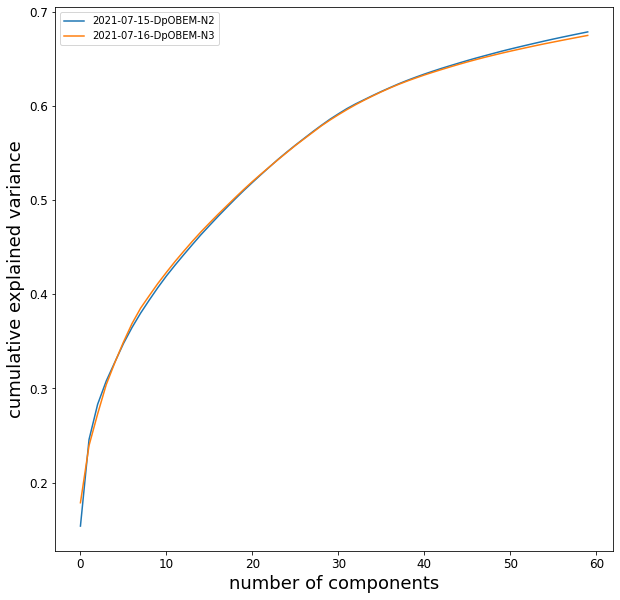

In [33]:
region = 'Dp'
csplus = 'naive'
xexp_list = csplus_dict[csplus]
plt.subplots(figsize=[10,10])
print(xexp_list)
for exp in xexp_list:
    pca1 = pca_all_dict[exp][region]['pca']
    plt.plot(np.cumsum(pca1.explained_variance_ratio_[:60]),label=exp)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.legend()



### PCA with lower number of components

In [91]:
n_components = 200
pca_dict = compute_pca_explist(n_components) 

2021-02-05-DpOBEM-JH9 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-02-05-DpOBEM-JH9 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-03-18-DpOBEM-JH10 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-03-18-DpOBEM-JH10 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-03-19-DpOBEM-JH10 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-03-19-DpOBEM-JH10 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-04-02-DpOBEM-JH11 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-04-02-DpOBEM-JH11 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-04-03-DpOBEM-JH11 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-04-03-DpOBEM-JH11 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-05-01-DpOBEM-JH13 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-05-01-DpOBEM-JH13 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-05-22-DpOBEM-JH14 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-05-22-DpOBEM-JH14 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-07-15-DpOBEM-N2 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-07-15-DpOBEM-N2 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-07-16-DpOBEM-N3 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-07-16-DpOBEM-N3 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-07-30-DpOBEM-JH17 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-07-30-DpOBEM-JH17 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-07-31-DpOBEM-JH17 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-07-31-DpOBEM-JH17 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-09-02-DpOBEM-JH18 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-09-02-DpOBEM-JH18 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-09-03-DpOBEM-JH18 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-09-03-DpOBEM-JH18 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-09-04-DpOBEM-JH18 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-09-04-DpOBEM-JH18 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-09-15-DpOBEM-JH20 Dp
2021-09-15-DpOBEM-JH20 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-09-17-DpOBEM-JH20 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-09-17-DpOBEM-JH20 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-09-18-DpOBEM-JH20 Dp


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


2021-09-18-DpOBEM-JH20 OB


/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


0.11697460497094568


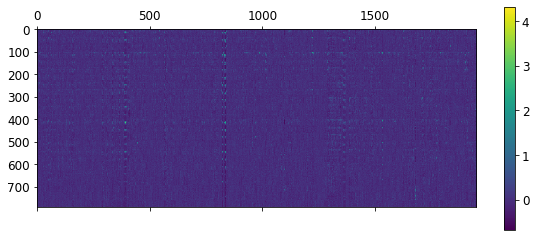

In [23]:
df = list(std_pattern_dict.values())[1]['Dp']
df.max().max()
plt.matshow(df)
plt.colorbar()
print(df.values.std())
#plt.clim((-1,3))

### Plot example traces for each principal component

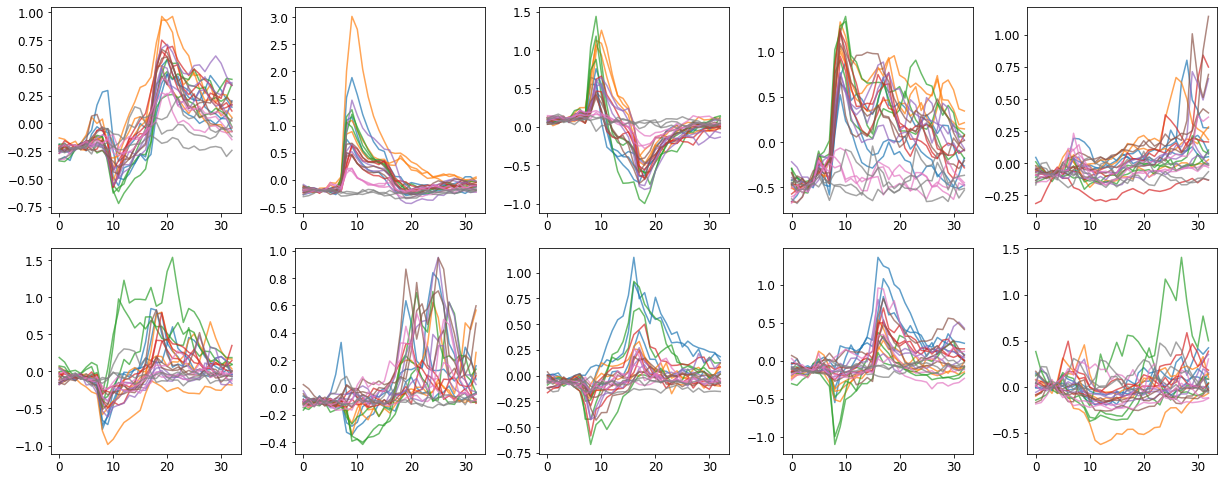

In [52]:
#importlib.reload(emb)
plot_explist_pca_1d = ecl.plot_explist_decorator(emb.plot_embed_1d, csplus_dict, pca_dict)
csplus = 'phe'
region = 'Dp'
fig = plot_explist_pca_1d(csplus, region, 1)

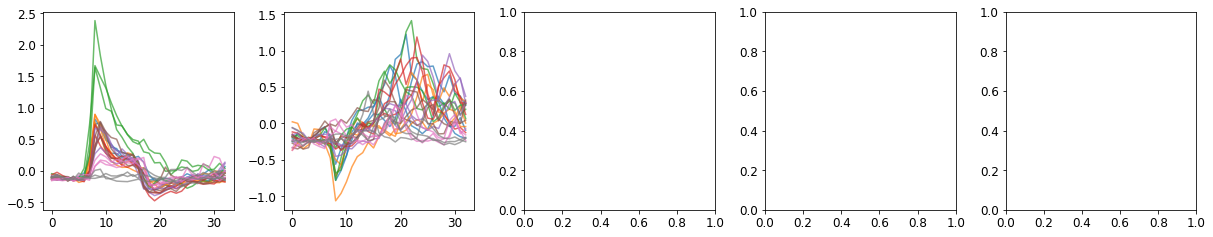

In [53]:
csplus = 'naive'
region = 'Dp'
fig = plot_explist_pca_1d(csplus, region, 1)

### Plot 2D component values

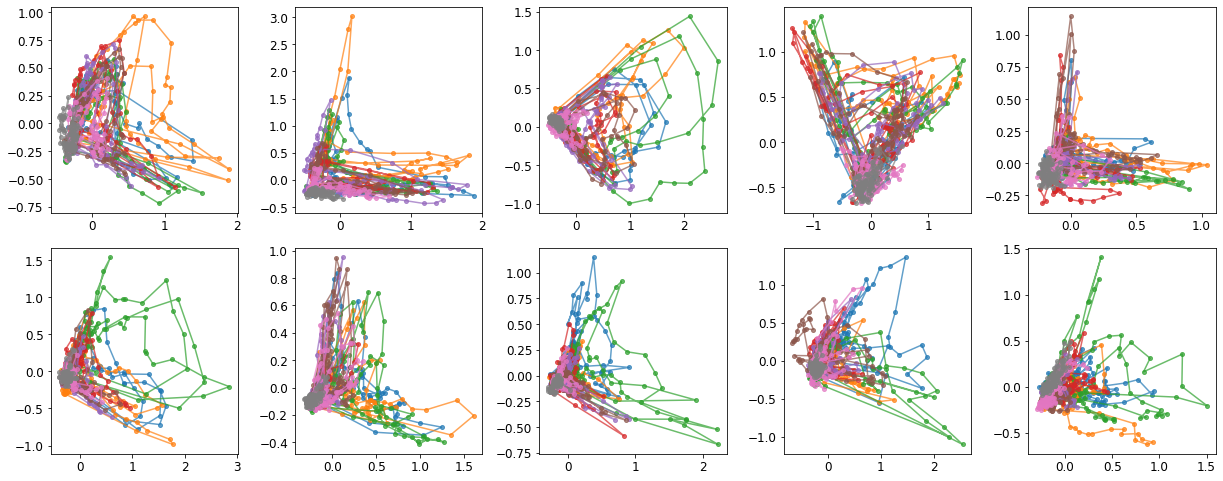

In [54]:
plot_explist_pca= ecl.plot_explist_decorator(emb.plot_embed_2d, csplus_dict, pca_dict)
csplus = 'phe'
region = 'Dp'
fig = plot_explist_pca(csplus, region, (0,1))

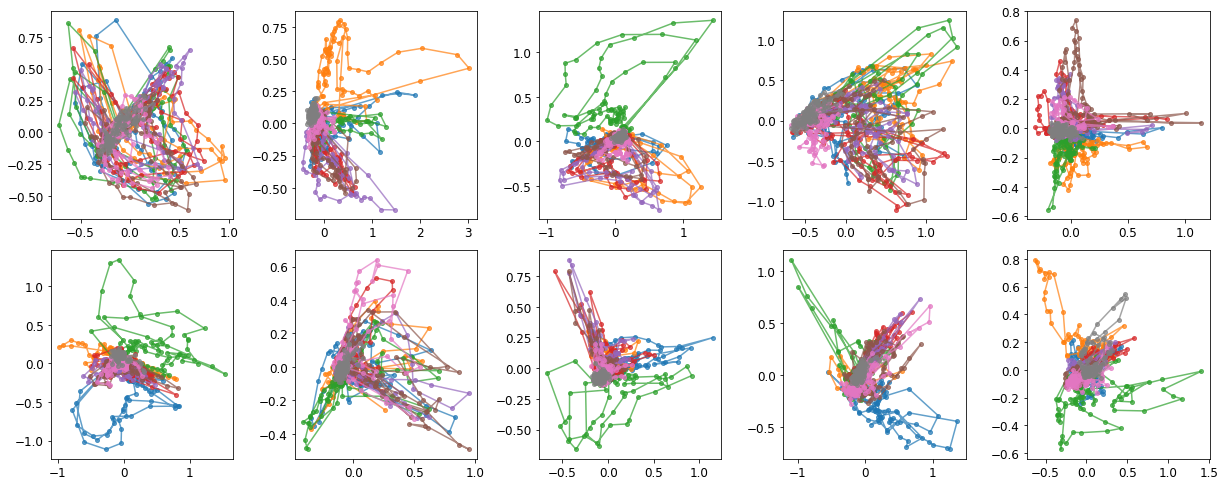

In [99]:
csplus = 'phe'
region = 'Dp'
fig = plot_explist_pca(csplus, region, (1,2))

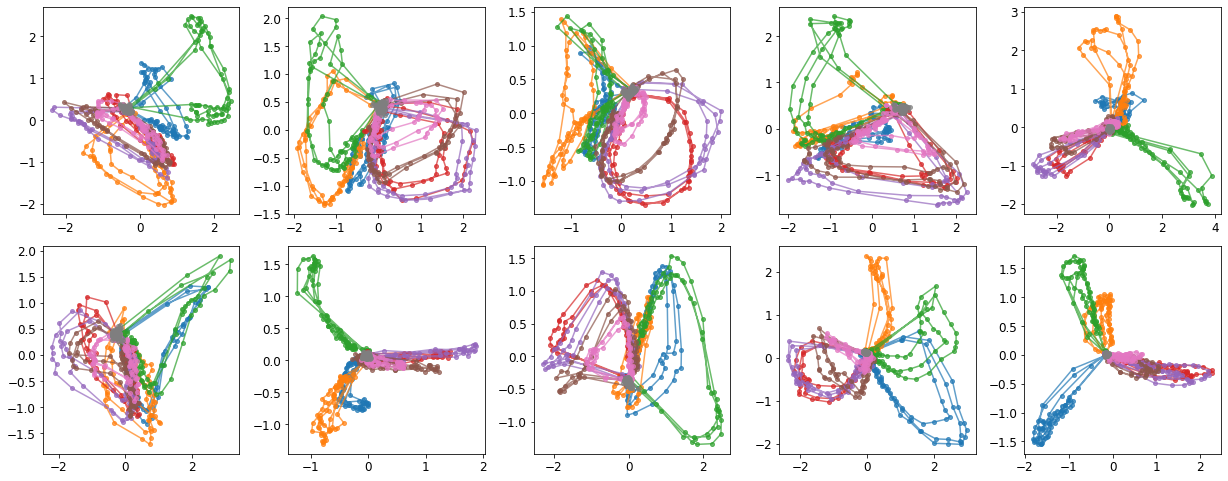

In [100]:
csplus = 'phe'
region = 'OB'
fig = plot_explist_pca(csplus, region, (1,2))

## Canonical component analysis

In [38]:
import sys
sys.path.insert(0, '/home/hubo/Projects/Ca_imaging/scripts/cca/pyrcca')
import rcca
rcca.__file__

'/home/hubo/Projects/Ca_imaging/scripts/cca/pyrcca/rcca/__init__.py'

In [94]:
importlib.reload(rcca)
# Create a cca object as an instantiation of the CCA object class. 
nComponents = 10
cca = rcca.CCA(kernelcca = False, reg = 0., numCC = nComponents)
region = 'Dp'
csplus = 'phe'
csexp_list = csplus_dict[csplus].copy()
csplus = 'arg'
csexp_list.extend(csplus_dict[csplus])
csplus = 'naive'
csexp_list.extend(csplus_dict[csplus])
# del csexp_list[9]
print(csexp_list)
data_list = [pca_dict[exp][region]['latent'] for exp in csexp_list]
#randmat = np.random.normal(scale=pp.std(), size=pp.shape)
#data_list.append(randmat)
# Use the train() method to find a CCA mapping between the two training sets.
cca.train(data_list)

['2021-02-05-DpOBEM-JH9', '2021-03-18-DpOBEM-JH10', '2021-03-19-DpOBEM-JH10', '2021-04-02-DpOBEM-JH11', '2021-04-03-DpOBEM-JH11', '2021-05-01-DpOBEM-JH13', '2021-05-22-DpOBEM-JH14', '2021-09-15-DpOBEM-JH20', '2021-09-17-DpOBEM-JH20', '2021-09-18-DpOBEM-JH20', '2021-07-30-DpOBEM-JH17', '2021-07-31-DpOBEM-JH17', '2021-09-02-DpOBEM-JH18', '2021-09-03-DpOBEM-JH18', '2021-09-04-DpOBEM-JH18', '2021-07-15-DpOBEM-N2', '2021-07-16-DpOBEM-N3']
Training CCA, kernel = None, regularization = 0.0000, 10 components


In [19]:
rcca.__file__

'/home/hubo/Softwares/anaconda3/envs/catrace/lib/python3.9/site-packages/rcca/__init__.py'

In [58]:
cca.ws

[array([[-1.12385221e-02, -5.27248175e-03, -4.17858467e-03, ...,
          1.10832111e-03, -5.82951421e-03, -4.31215202e-04],
        [ 4.40861205e-03, -3.68539113e-04, -2.17002793e-03, ...,
         -9.52184696e-04, -3.20948062e-03,  9.86380958e-04],
        [ 5.60055733e-05, -6.16919480e-04, -4.01831332e-03, ...,
         -7.99368451e-04,  2.60443879e-03,  9.83090452e-04],
        ...,
        [ 6.38225247e-03,  7.84378129e-04,  1.34365177e-03, ...,
          3.48007020e-03, -1.14066851e-04, -8.09034047e-04],
        [ 1.82964394e-03,  9.01877591e-04, -6.77674022e-04, ...,
          3.96820519e-04, -1.18902069e-03, -1.95908415e-03],
        [-9.29538548e-04,  2.08321142e-03,  2.04570782e-03, ...,
         -2.26751525e-04, -1.58835207e-03, -2.19255646e-03]]),
 array([[-3.59283498e-03, -2.35760295e-03, -1.21734887e-03, ...,
          5.43902989e-04, -5.85921596e-04, -2.14200635e-04],
        [-9.51152836e-03, -7.00482607e-03, -7.27327846e-03, ...,
         -1.29906024e-03, -1.94716879e

['phe', 'phe', 'phe', 'phe', 'phe', 'phe', 'phe', 'phe', 'phe', 'phe', 'arg', 'arg', 'arg', 'arg', 'arg', 'naive', 'naive']


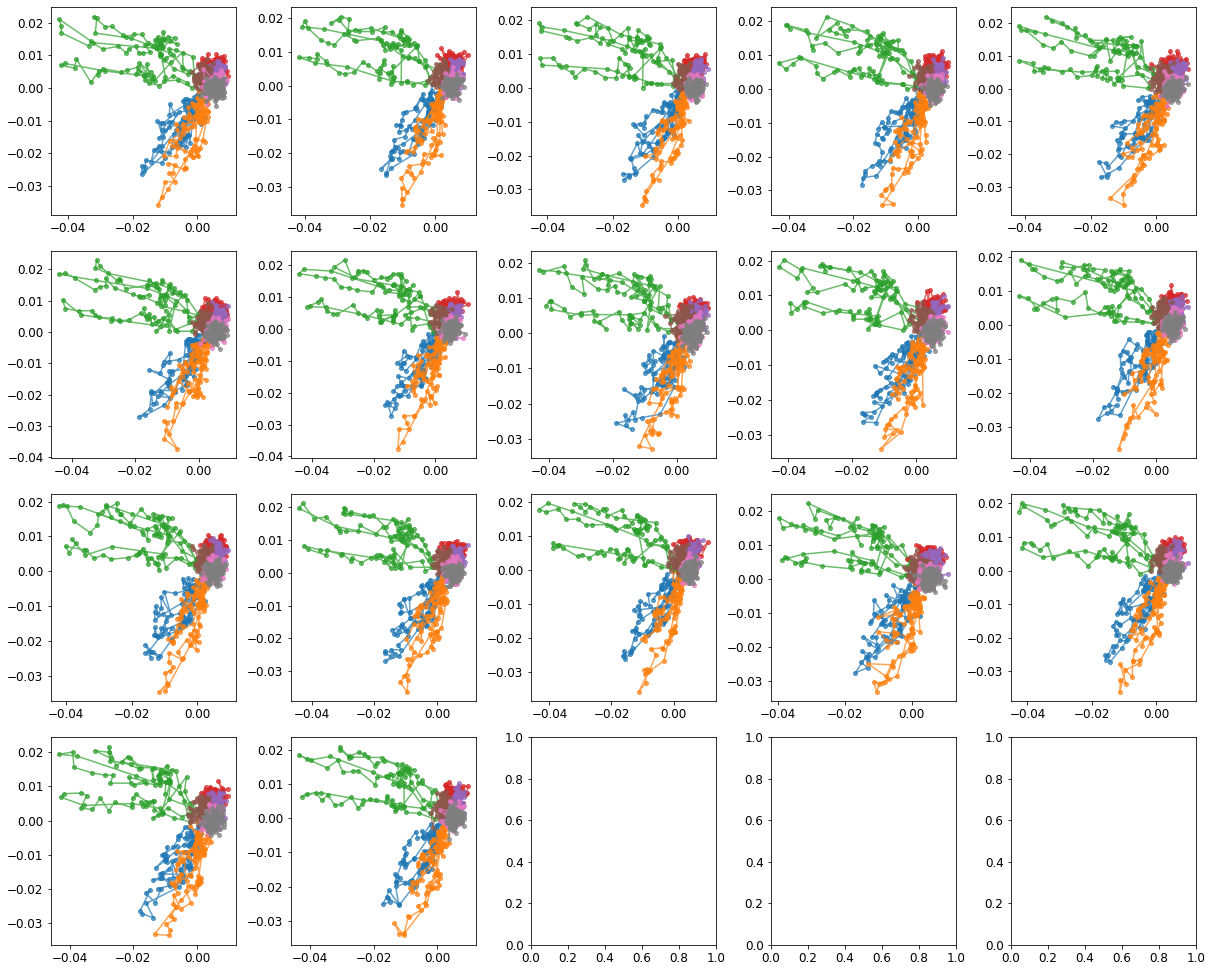

In [95]:
importlib.reload(ecl)
xx_dict = dict(exp_list)
xx_list = [xx_dict[exp] for exp in csexp_list]
print(xx_list)
plot_func = emb.plot_embed_2d
ccacomp_list = [dict(latent=comps, index=pca_dict[exp_list[idx][0]][region]['index']) for idx,comps in enumerate(cca.comps)]
fig = ecl.plot_explist(ccacomp_list, plot_func, False, False, component_idx=(0,1))

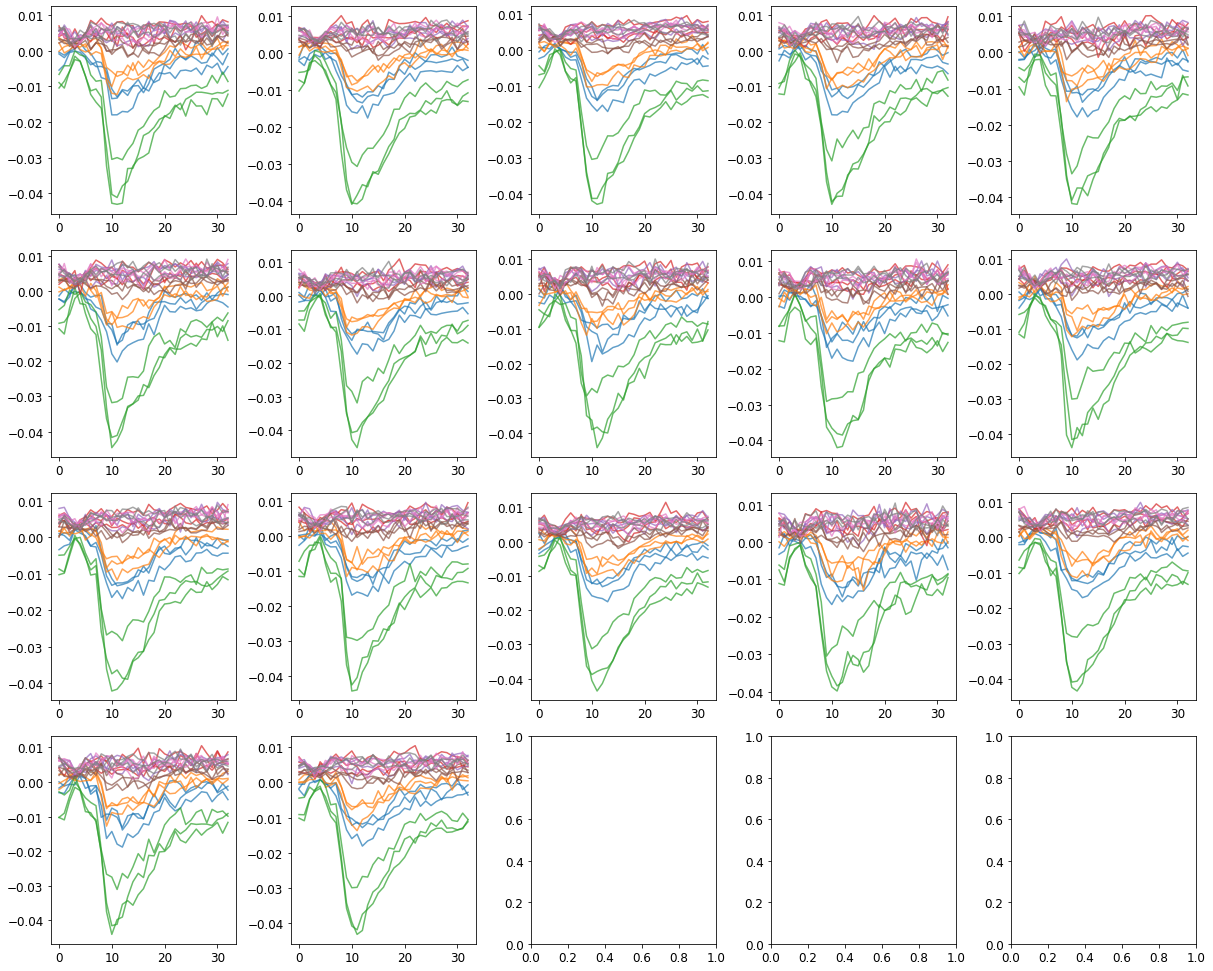

In [76]:
plot_func = emb.plot_embed_1d
ccacomp_list = [dict(latent=comps, index=pca_dict[exp_list[idx][0]][region]['index']) for idx,comps in enumerate(cca.comps)]
fig = ecl.plot_explist(ccacomp_list, plot_func, False, False, component_idx=0)

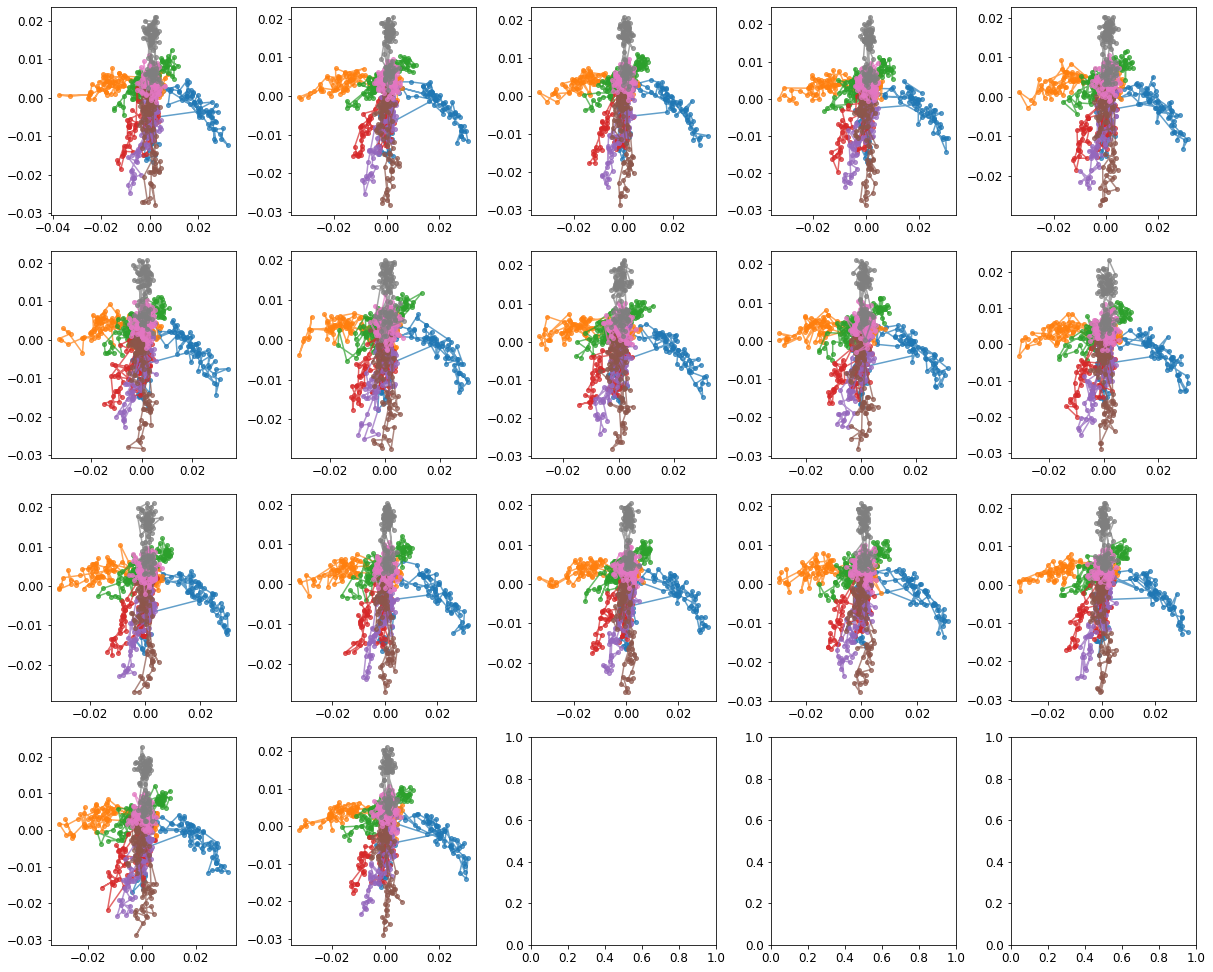

In [97]:
fig = ecl.plot_explist(ccacomp_list, plot_func, False, False, component_idx=(2,3))

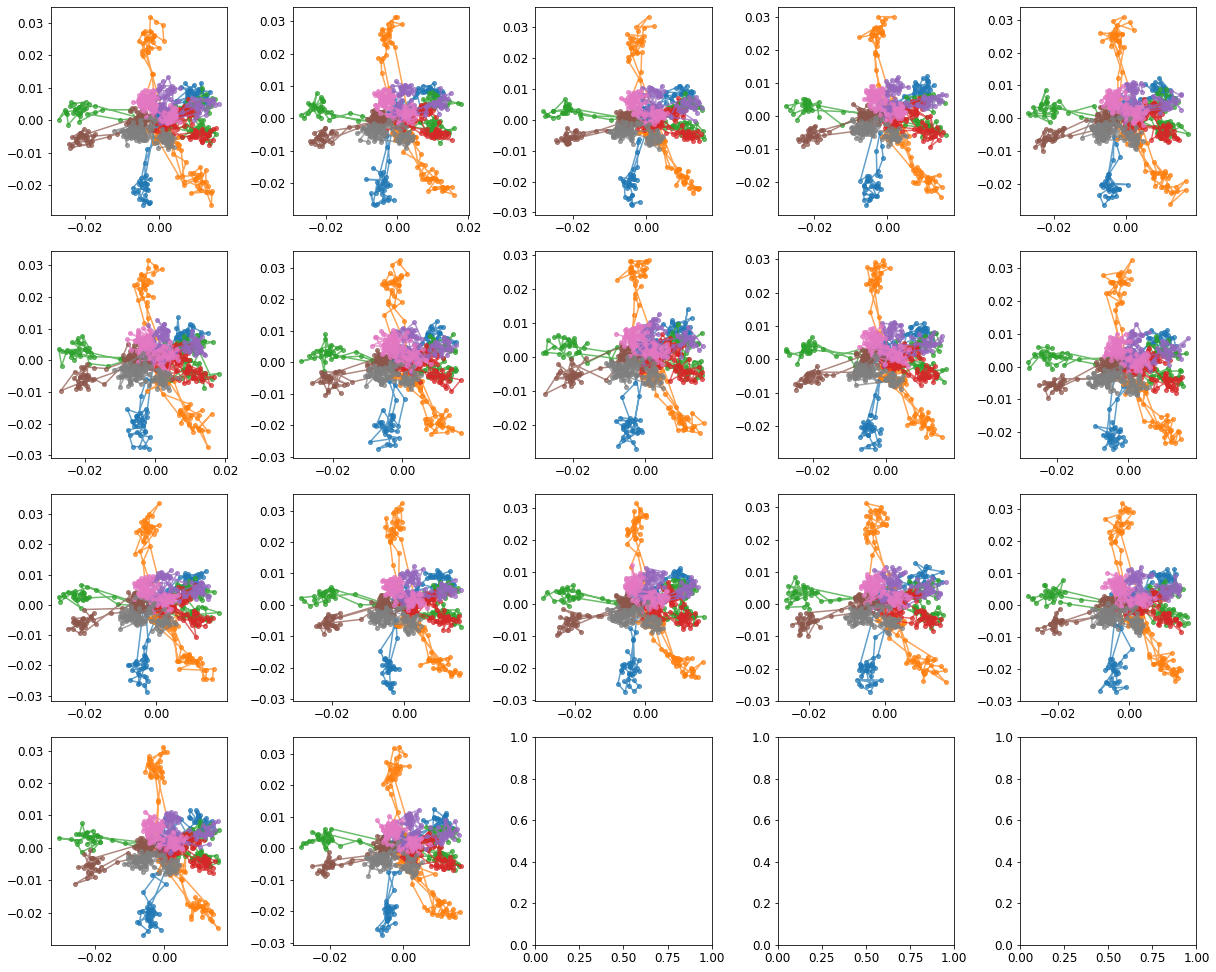

In [49]:
fig = ecl.plot_explist(ccacomp_list, plot_func, False, False, component_idx=(4,5))

In [139]:
# Create a cca object as an instantiation of the CCA object class. 
nComponents = 10
cca = rcca.CCA(kernelcca = False, reg = 0., numCC = nComponents)
#region_list = ['Dp', 'OB']
#exp_name = '2021-02-05-DpOBEM-JH9'
exp_region_list = [('2021-02-05-DpOBEM-JH9', 'Dp'), ('2021-03-19-DpOBEM-JH10','OB'), ('2021-07-15-DpOBEM-N2','Dp'),('2021-09-18-DpOBEM-JH20','OB')]
data_list = [pca_dict[expreg[0]][expreg[1]]['latent'] for expreg in exp_region_list]
expreg = exp_region_list[0]
pp = pca_dict[expreg[0]][expreg[1]]['latent']
randmat = np.random.normal(scale=pp.std(), size=pp.shape)
data_list.append(randmat)
# Use the train() method to find a CCA mapping between the two training sets.
cca.train(data_list)

Training CCA, kernel = None, regularization = 0.0000, 10 components


In [55]:
nComponents = 10
cca = rcca.CCA(kernelcca = False, reg = 0., numCC = nComponents)
region = 'OB'
csplus = 'phe'
csexp_list = csplus_dict[csplus].copy()
csplus = 'arg'
csexp_list.extend(csplus_dict[csplus])
csplus = 'naive'
csexp_list.extend(csplus_dict[csplus])
# del csexp_list[9]
print(csexp_list)
data_list = [pca_dict[exp][region]['latent'] for exp in csexp_list]
#randmat = np.random.normal(scale=pp.std(), size=pp.shape)
#data_list.append(randmat)
# Use the train() method to find a CCA mapping between the two training sets.
cca.train(data_list)

['2021-02-05-DpOBEM-JH9', '2021-03-18-DpOBEM-JH10', '2021-03-19-DpOBEM-JH10', '2021-04-02-DpOBEM-JH11', '2021-04-03-DpOBEM-JH11', '2021-05-01-DpOBEM-JH13', '2021-05-22-DpOBEM-JH14', '2021-09-15-DpOBEM-JH20', '2021-09-17-DpOBEM-JH20', '2021-09-18-DpOBEM-JH20', '2021-07-30-DpOBEM-JH17', '2021-07-31-DpOBEM-JH17', '2021-09-02-DpOBEM-JH18', '2021-09-03-DpOBEM-JH18', '2021-09-04-DpOBEM-JH18', '2021-07-15-DpOBEM-N2', '2021-07-16-DpOBEM-N3']
Training CCA, kernel = None, regularization = 0.0000, 10 components


['phe', 'phe', 'phe', 'phe', 'phe', 'phe', 'phe', 'phe', 'phe', 'phe', 'arg', 'arg', 'arg', 'arg', 'arg', 'naive', 'naive']


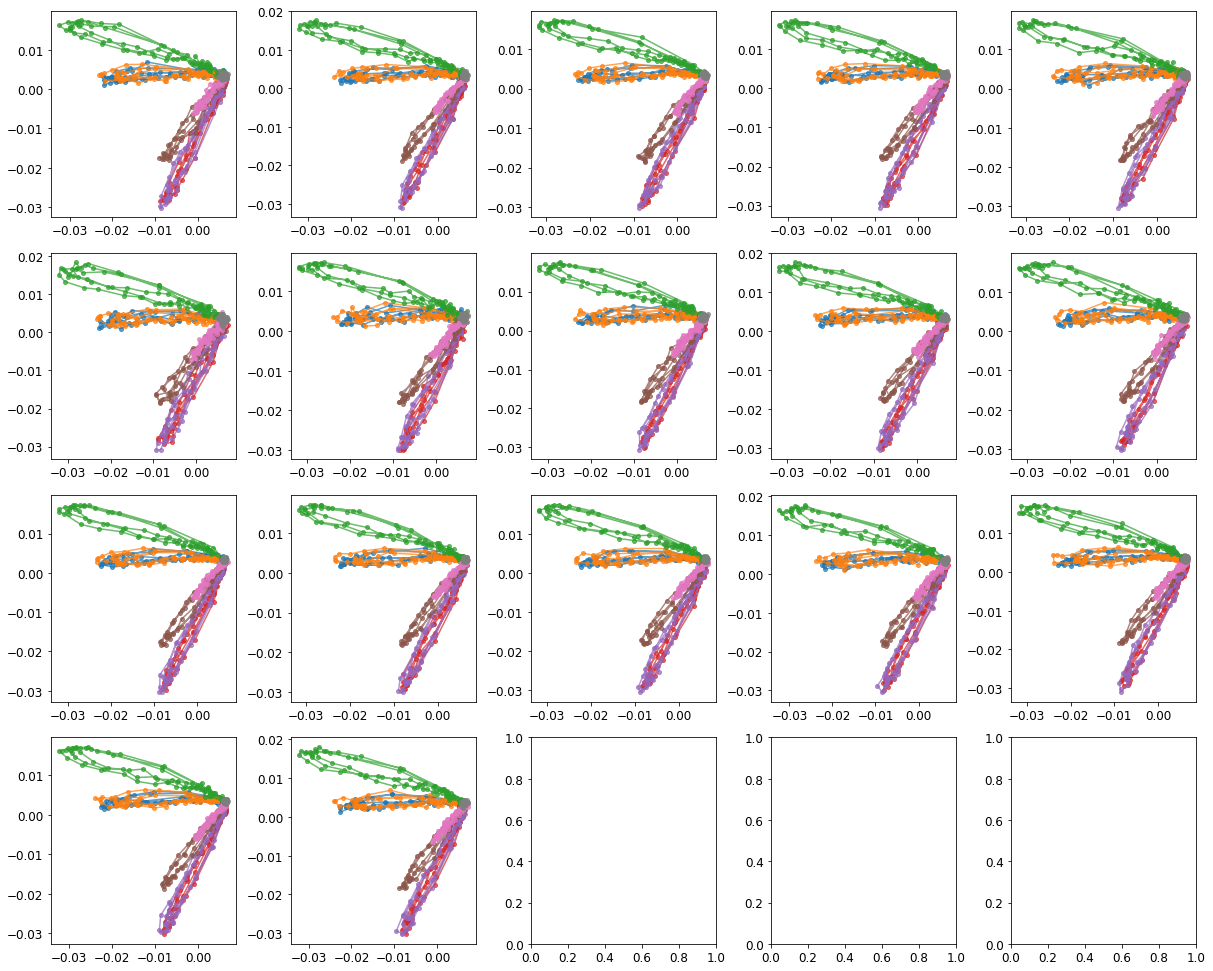

In [56]:
importlib.reload(ecl)
xx_dict = dict(exp_list)
xx_list = [xx_dict[exp] for exp in csexp_list]
print(xx_list)
plot_func = emb.plot_embed_2d
ccacomp_list = [dict(latent=comps, index=pca_dict[exp_list[idx][0]][region]['index']) for idx,comps in enumerate(cca.comps)]
fig = ecl.plot_explist(ccacomp_list, plot_func, False, False, component_idx=(0,1))

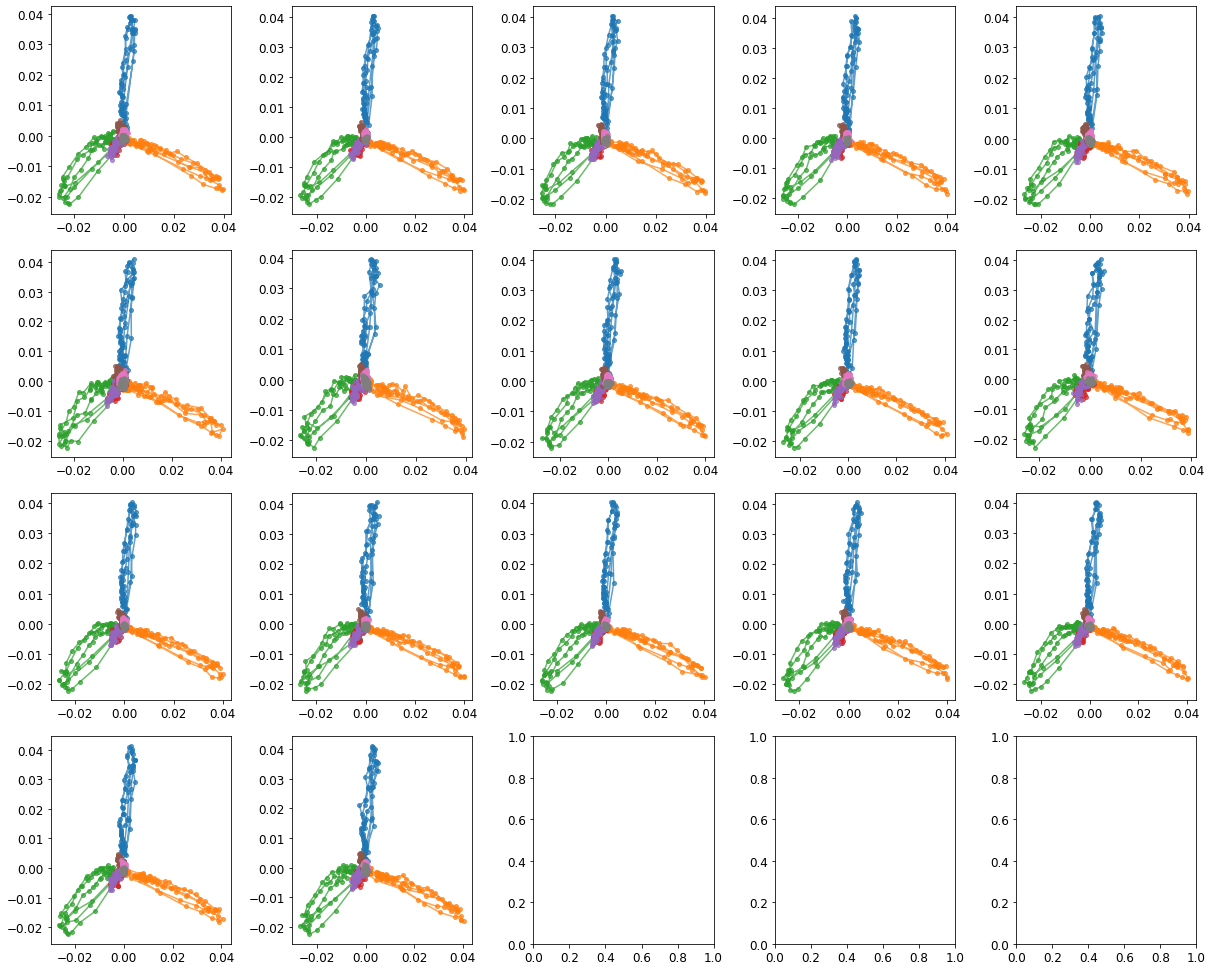

In [57]:
fig = ecl.plot_explist(ccacomp_list, plot_func, False, False, component_idx=(2,3))

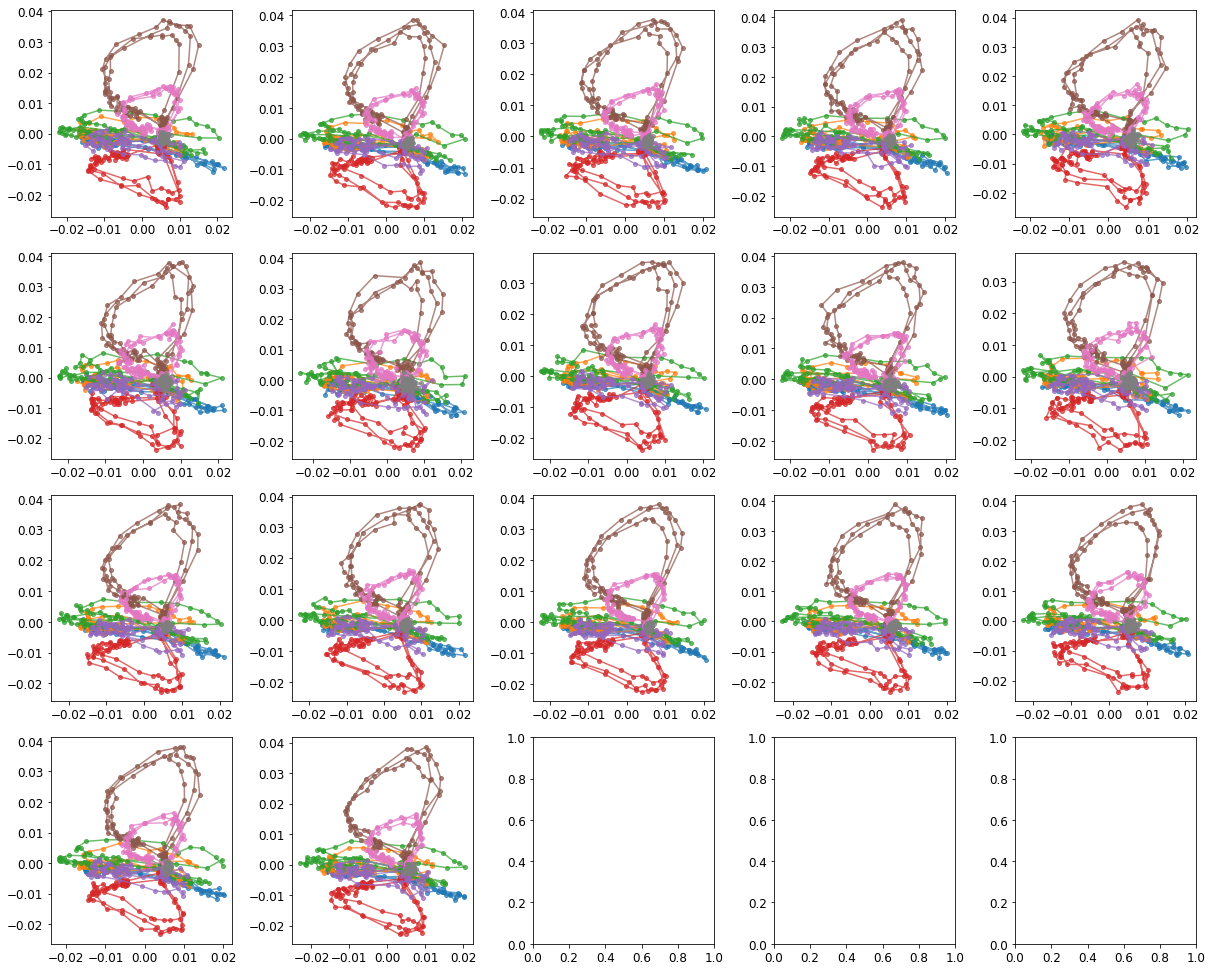

In [58]:
fig = ecl.plot_explist(ccacomp_list, plot_func, False, False, component_idx=(4,5))

['phe', 'phe', 'phe', 'phe', 'phe', 'phe', 'phe', 'phe', 'phe', 'phe', 'arg', 'arg', 'arg', 'arg', 'arg', 'naive', 'naive']


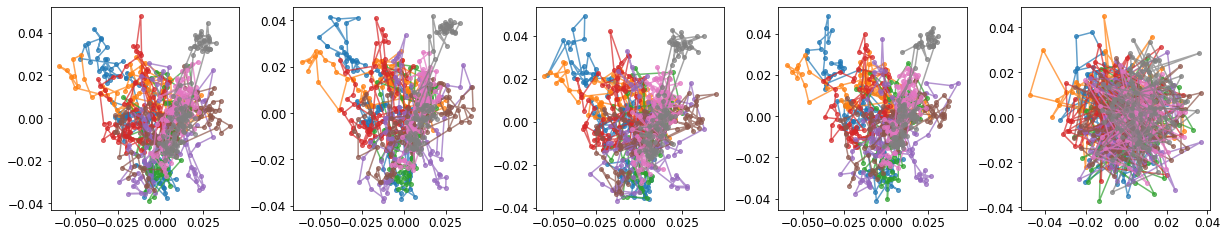

In [140]:
# Through a random ball, to mess up the alignment
importlib.reload(ecl)
xx_dict = dict(exp_list)
xx_list = [xx_dict[exp] for exp in csexp_list]
print(xx_list)
plot_func = emb.plot_embed_2d
ccacomp_list = [dict(latent=comps, index=svd_dict[exp_list[idx][0]][region]['index']) for idx,comps in enumerate(cca.comps)]
fig = ecl.plot_explist(ccacomp_list, plot_func, False, False, component_idx=(0,1))

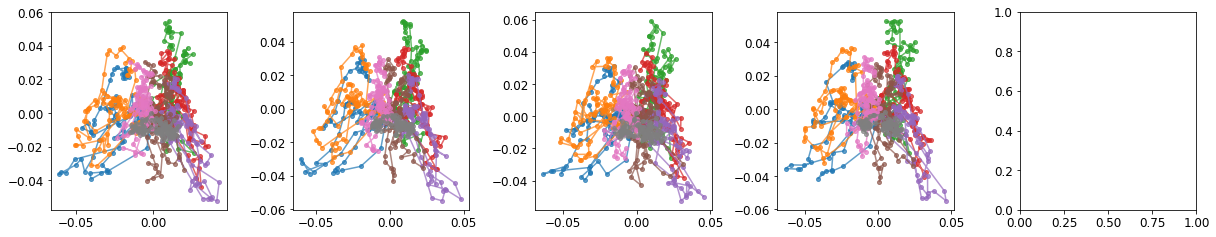

In [134]:
fig = ecl.plot_explist(ccacomp_list, plot_func, False, False, component_idx=(2,3))

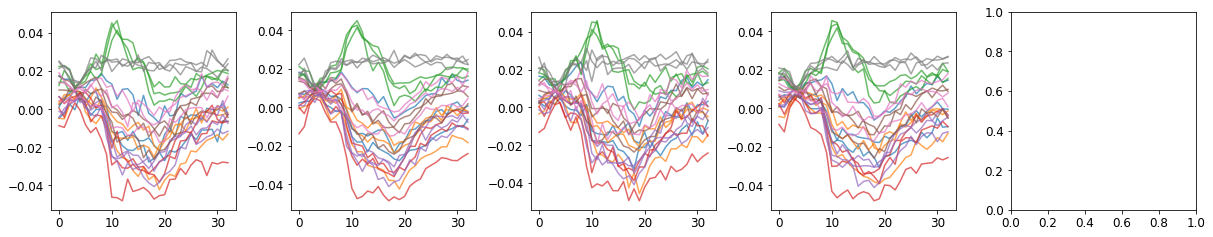

In [136]:
plot_func = emb.plot_embed_1d
ccacomp_list = [dict(latent=comps, index=svd_dict[exp_list[idx][0]][region]['index']) for idx,comps in enumerate(cca.comps)]
fig = ecl.plot_explist(ccacomp_list, plot_func, False, False, component_idx=1)

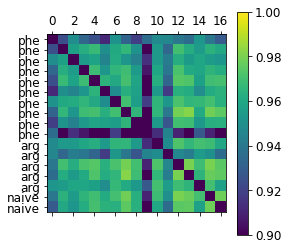

In [129]:
plot_cancorr_mat_mean(cca.cancorrs, xx_list, clim=(0.9,1))